In [5]:
import tensorflow as tf
import pandas as pd
import math
import numpy
from tensorflow import keras

from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.training import optimizer

SHUFFLE_BUFFER = 500
BATCH_SIZE = 36
EPOCHS = 3

In [6]:
data = pd.read_csv('data/prepared_data.csv')

TRAINING_SIZE = math.floor(0.5*len(data))
TEST_SIZE = math.floor(0.3*len(data))
EVALUATION_SIZE = math.floor(0.2*len(data))

indices = (TRAINING_SIZE, TRAINING_SIZE+TEST_SIZE, TRAINING_SIZE+TEST_SIZE+EVALUATION_SIZE)
inputs = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift']
outputs = ['class_GALAXY','class_QSO','class_STAR']

training = data[0:indices[0]]
test = data[indices[0]:indices[1]]
evaluation = data[indices[1]:indices[2]]
professor = {
	"training": {
		"questions": training[inputs],
		"answers": training[outputs]
	},
	"test": {
		"questions": test[inputs],
		"answers": test[outputs]
	},
	"evaluation": {
		"questions": evaluation[inputs],
		"answers": evaluation[outputs]
	}
}

In [13]:
from pprint import pprint
def cgd(tups):
	print(tups)
	return tups


def debug(x):
	with open('cgd.log', 'a') as log:
		print(x, file=log)

class CGD(optimizer.Optimizer):

	def __init__(self) -> None:
		super().__init__(name="CGD", use_locking=False)
		self.learning_rate = 0.2

	def __hessian(self, x):
		"""
		Calculate the hessian matrix with finite differences
		Parameters:
		- x : ndarray
		Returns:
		an array of shape (x.dim, x.ndim) + x.shape
		where the array[i, j, ...] corresponds to the second derivative x_ij
		"""
		x_grad = np.gradient(x) 
		hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype=x.dtype) 
		for k, grad_k in enumerate(x_grad):
			# iterate over dimensions
			# apply gradient again to every component of the first derivative.
			tmp_grad = np.gradient(grad_k) 
			for l, grad_kl in enumerate(tmp_grad):
				hessian[k, l, :, :] = grad_kl
		return hessian

	def _resource_apply_dense(self, grad, var):
		var_update = state_ops.assign_sub(var, self.learning_rate * grad) 
		
		return control_flow_ops.group(*[var_update])

	def _resource_apply_sparse(self, grad, var):
		raise NotImplementedError("Sparse gradient updates are not supported yet.")

	def _create_slots(self, var_list):
		pass

	def get_config():
		return {}



In [19]:
normalizer = keras.layers.Normalization(axis=-1)
normalizer.adapt(data[['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift']])

model = keras.Sequential([
	normalizer,
	keras.layers.Dense(9, activation='relu'),
	keras.layers.Dense(9, activation='relu'),
	keras.layers.Dense(3, activation='sigmoid')
])


model.compile(
	CGD(),
	loss=keras.losses.BinaryCrossentropy(),
	metrics=['accuracy']
)

history = model.fit(professor['training']['questions'], professor['training']['answers'], validation_data=(professor['test']['questions'], professor['test']['answers']), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/3
[<tf.Variable 'dense_15/kernel:0' shape=(8, 9) dtype=float32, numpy=
array([[ 0.5519004 , -0.42896855, -0.5152494 , -0.2553669 ,  0.3727247 ,
        -0.07774317,  0.24943763, -0.5318543 ,  0.48626506],
       [ 0.05598176,  0.18538028, -0.02103949, -0.5446934 ,  0.13725823,
         0.2947467 , -0.26137266, -0.03145057,  0.41837287],
       [-0.19356817,  0.5930439 ,  0.58800673,  0.23637372, -0.3295835 ,
         0.42920136, -0.4566214 , -0.22900978,  0.02722156],
       [ 0.2651015 ,  0.5709691 ,  0.18345594, -0.3758818 ,  0.569842  ,
        -0.03085554,  0.08374214, -0.5433257 , -0.46422178],
       [-0.5864648 ,  0.45783854, -0.11351794, -0.5629857 ,  0.41962993,
         0.01611149, -0.24128374,  0.2238056 ,  0.55620575],
       [ 0.29530478,  0.13470823,  0.4961487 ,  0.3010894 , -0.10437426,
         0.00319415,  0.37104374,  0.04973167,  0.16364467],
       [ 0.5058415 , -0.4856751 ,  0.40747106,  0.3469022 , -0.5905856 ,
         0.15863127,  0.16747284, -0.1483551

In [15]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 8)                 17        
_________________________________________________________________
dense_12 (Dense)             (None, 9)                 81        
_________________________________________________________________
dense_13 (Dense)             (None, 9)                 90        
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 30        
Total params: 218
Trainable params: 201
Non-trainable params: 17
_________________________________________________________________


In [16]:
evaluation.head(5)

,Unnamed: 0,ra,dec,u,g,r,i,z,redshift,class_GALAXY,class_QSO,class_STAR
8000,8000,0.190349,-0.599724,-0.079026,-0.204305,-0.154887,-0.110684,-0.030056,-0.370001,0.1,0.1,0.9
8001,8001,0.188651,-0.598305,0.745707,0.702019,0.629892,0.602372,0.601848,-0.367239,0.1,0.1,0.9
8002,8002,0.190667,-0.604786,1.004693,0.648648,0.312791,0.092810,-0.032583,-0.091988,0.9,0.1,0.1
8003,8003,0.191552,-0.603357,0.394077,1.518491,1.645257,1.595851,1.568480,3.531147,0.1,0.9,0.1
8004,8004,0.191230,-0.598623,-1.215336,-1.586335,-1.722162,-1.761351,-1.850619,-0.164494,0.9,0.1,0.1


In [17]:
model.__call__(professor['evaluation']['questions'].head(5))

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.27271637, 0.11935154, 0.70049185],
       [0.37744   , 0.12356421, 0.5960483 ],
       [0.8869987 , 0.11021402, 0.11056831],
       [0.1016371 , 0.9218199 , 0.05841032],
       [0.91925144, 0.07718682, 0.08133894]], dtype=float32)>

Text(0.5, 1.0, 'Training and Validation Accuracy')

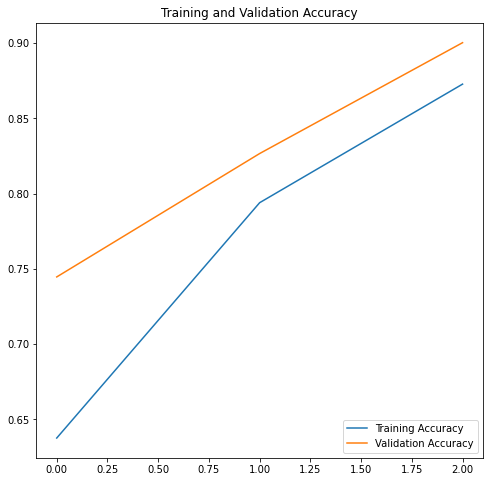

In [18]:

import matplotlib.pyplot as plt
epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, history.history["accuracy"], label='Training Accuracy')
plt.plot(epochs_range, history.history["val_accuracy"], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')